In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import numpy as np

In [2]:
np.random.seed(0)
tf.random.set_seed(0)
tfd = tfp.distributions
tfb = tfp.bijectors

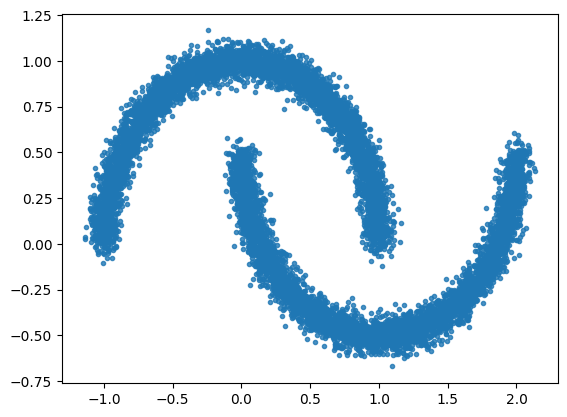

In [3]:
moon_n = 10000
ndim = 2
data, _ = datasets.make_moons(moon_n, noise=0.05) # TODO: Replace FUNCTION with appropriate function call to make moon
plt.plot(data[:, 0], data[:, 1], ".", alpha=0.8)

In [4]:
zdist = tfd.MultivariateNormalDiag(loc=[0.0] * ndim)
zdist


<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

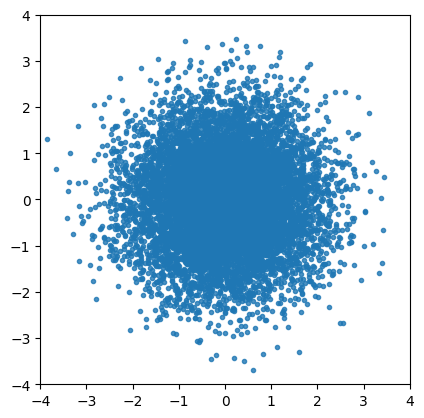

In [5]:
zsamples = zdist.sample(moon_n) # TODO: Make call to z-distribution sampling function (Refer docs)
plt.plot(zsamples[:, 0], zsamples[:, 1], ".", alpha=0.8)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect("equal")


In [12]:
tfd = tfp.distributions
tfb = tfp.bijectors

# Define the shift bijector
shift_bij = tfb.Shift(shift=tf.constant([0.0, 0.0]))

# Define the scale bijector
scale_bij = tfb.Scale(scale=tf.constant([1.0, 1.0]))

# Chain the bijectors together
b = tfb.Chain([shift_bij, scale_bij])

In [13]:
td = tfd.TransformedDistribution(zdist, bijector=b)
td


<tfp.distributions.TransformedDistribution 'chain_of_shift_of_scaleMultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

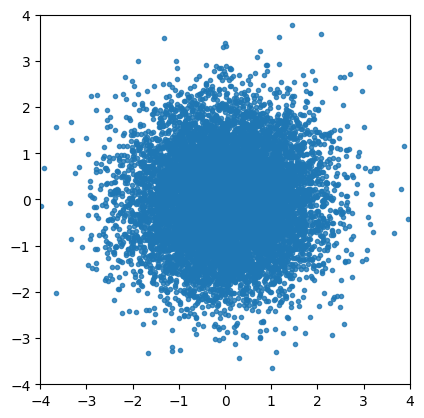

In [14]:
zsamples = td.sample(moon_n)
plt.plot(zsamples[:, 0], zsamples[:, 1], ".", alpha=0.8)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect("equal")


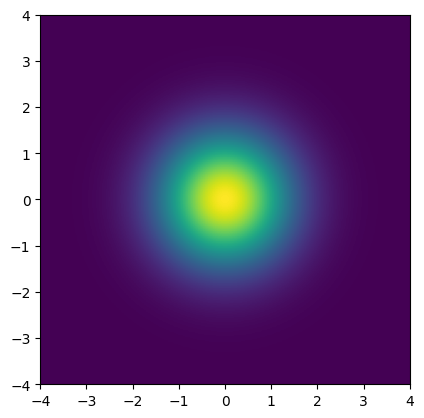

In [15]:
# make points for grid
zpoints = np.linspace(-4, 4, 150)
(
z1,
z2,
) = np.meshgrid(zpoints, zpoints)
zgrid = np.concatenate((z1.reshape(-1, 1), z2.reshape(-1, 1)), axis=1)
# compute P(x)
p = np.exp(td.log_prob(zgrid))
fig = plt.figure()
# plot and set axes limits
plt.imshow(p.reshape(z1.shape), aspect="equal", extent=[-4, 4, -4, 4])
plt.show()


In [17]:
num_layers = 3
my_bijects = []
# loop over desired bijectors and put into list
for i in range(num_layers):
  # Syntax to make a MAF
  anet = tfb.AutoregressiveNetwork(params=2, hidden_units=[128, 128], activation='relu')
  # TODO: Autoregressive Network with hidden units [128, 128] and relu activation

  ab = tfb.MaskedAutoregressiveFlow(anet)

  # Add bijector to list
  my_bijects.append(ab)

  # Now permuate (!important!)
  permute = tfb.Permute(permutation=np.random.permutation(ndim)) # TODO: tfb Permute
  my_bijects.append(permute)

# put all bijectors into one "chain bijector" that looks like one
big_bijector = tfb.Chain(my_bijects) # TODO: tfb Chain

# make transformed dist
td = tfd.TransformedDistribution(zdist, bijector=big_bijector)


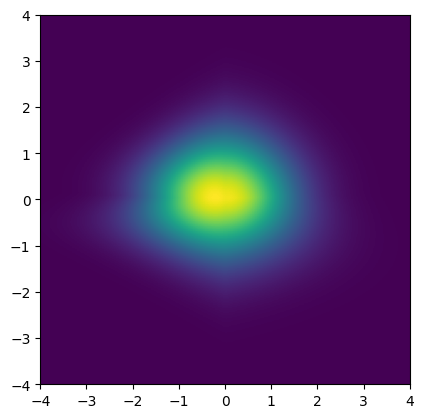

In [18]:
zpoints = np.linspace(-4, 4, 150)
(
z1,
z2,
) = np.meshgrid(zpoints, zpoints)
zgrid = np.concatenate((z1.reshape(-1, 1), z2.reshape(-1, 1)), axis=1)
p = np.exp(td.log_prob(zgrid))
fig = plt.figure()
plt.imshow(p.reshape(z1.shape), aspect="equal", extent=[-4, 4, -4, 4])
plt.show()

In [20]:
# declare the feature dimension
x = tf.keras.Input(shape=(ndim,), dtype=tf.float32) # TODO: Appropriate shape and dtype

# create a "placeholder" function that will be model output
log_prob = td.log_prob(x)

# use input (feature) and output (log prob) to make model
model = tf.keras.Model(inputs=x, outputs=log_prob) # TODO: tf keras Model

# define a loss
def neg_loglik(yhat, log_prob):
  # losses always take in label, prediction
  # in keras. We do not have labels,
  # but we still need to accept the arg
  # to comply with Keras format
  return -log_prob

# now we prepare model for training
model.compile(optimizer=tf.keras.optimizers.Adam(), loss= neg_loglik) # TODO: Adam optimizer, appropriate loss function call


Epoch 1/80
313/313 [==============================] - 4s 4ms/step - loss: 1.5673
Epoch 2/80
313/313 [==============================] - 1s 5ms/step - loss: 1.3499
Epoch 3/80
313/313 [==============================] - 2s 5ms/step - loss: 1.2262
Epoch 4/80
313/313 [==============================] - 2s 5ms/step - loss: 1.0883
Epoch 5/80
313/313 [==============================] - 2s 7ms/step - loss: 1.3757
Epoch 6/80
313/313 [==============================] - 2s 5ms/step - loss: 1.0988
Epoch 7/80
313/313 [==============================] - 2s 5ms/step - loss: 0.8449
Epoch 8/80
313/313 [==============================] - 2s 5ms/step - loss: 0.7668
Epoch 9/80
313/313 [==============================] - 2s 5ms/step - loss: 0.7259
Epoch 10/80
313/313 [==============================] - 2s 5ms/step - loss: 0.6935
Epoch 11/80
313/313 [==============================] - 2s 5ms/step - loss: 0.6789
Epoch 12/80
313/313 [==============================] - 2s 6ms/step - loss: 0.6663
Epoch 13/80
313/313 [====

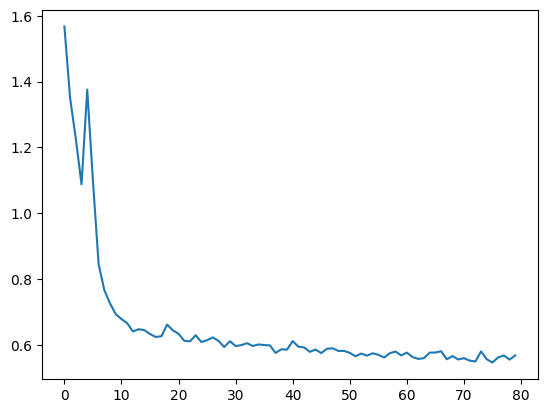

In [21]:
# TODO: Train with x=data, y from moon_n, for 80 epochs
result = model.fit(x=data, y=np.zeros(len(data)), epochs=80)

plt.plot(result.history["loss"])
plt.show()


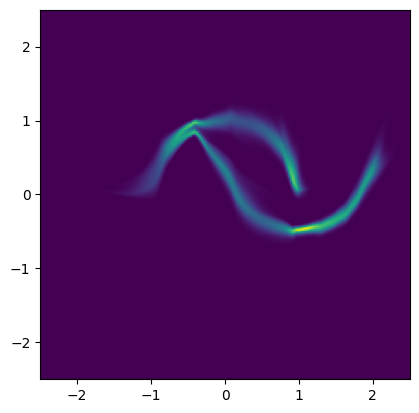

In [22]:
zpoints = np.linspace(-2.5, 2.5, 200)
(
z1,
z2,
) = np.meshgrid(zpoints, zpoints)
zgrid = np.concatenate((z1.reshape(-1, 1), z2.reshape(-1, 1)), axis=1)
p = np.exp(td.log_prob(zgrid))
fig = plt.figure()
plt.imshow(
p.reshape(z1.shape), aspect="equal", origin="lower", extent=[-2.5,
2.5, -2.5, 2.5]
)
plt.show()


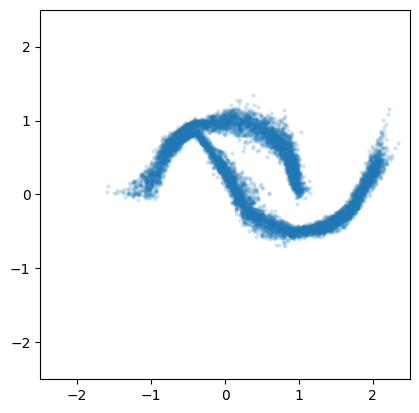

In [23]:
zsamples = td.sample(moon_n)
plt.plot(zsamples[:, 0], zsamples[:, 1], ".", alpha=0.2,
markeredgewidth=0.0)
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.gca().set_aspect("equal")